In [1]:
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO, DQN, A2C, DDPG
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
import numpy as np
import random
from shapely.geometry import Polygon,Point
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# import gym

print(gym.__version__)

0.29.1


Timeline \
<input type="checkbox" checked/> add clavon and a few other sites polygons \
<input type="checkbox" checked/> prepare the buildings to be added in \
<input type="checkbox"/> change the environment to just xy \
<input type="checkbox"/> Write evaluation script for interblock distance in inference, out of site, collision (Clarence)\
<input type="checkbox"/> Add GFA function\
<input type="checkbox" checked/> convert polygon into metres (Clarence)\
<input type="checkbox"/> scale the sites to the real life dimensions \
<input type="checkbox"/> Get the interblock distance for those sites, 30m for bedroom facing, 10m for bedroom not facing\
<input type="checkbox"/> add angle for the blocks, so action space is x,y,theta \
<input type="checkbox"/> Refactor environment code \
<input type="checkbox"/> write the feature extractor for the clavon site \
<input type="checkbox"/> Block view objective reward function \
<input type="checkbox"/> Get the context for each site \
<input type="checkbox"/> add a generative loss 

# Util functions for input data


In [2]:
# sting = '103.9184733 1.3092462, 103.9185355 1.3092515, 103.9185338 1.3092714, 103.9186415 1.3092804, 103.9186431 1.3092613, 103.9187158 1.3092674, 103.9187202 1.3092156, 103.9187321 1.3092166, 103.9187379 1.3091466, 103.9186642 1.3091404, 103.9186697 1.3090749, 103.9187467 1.3090814, 103.9187526 1.3090106, 103.9187395 1.3090095, 103.9187444 1.3089509, 103.9186749 1.3089451, 103.9186763 1.3089285, 103.9185696 1.3089195, 103.9185683 1.3089349, 103.9185011 1.3089292, 103.9184967 1.3089811, 103.9184756 1.3089793, 103.9184691 1.3090564, 103.918545 1.3090628, 103.9185392 1.3091312, 103.9184654 1.3091249, 103.9184593 1.3091968, 103.9184773 1.3091984, 103.9184733 1.3092462'
#replace "' "with ","


geo_list = [
    [0,0],
    [0,1.1],
    [1.5,1.1],
    [1.5,2],
    [0,2],
    [0,3],
    [7,3],
    [7,2],
    [5,2],
    [5,1.1],
    [7,1.1],
    [7,0],
    [4.5,0],
    [4.5,0.5],
    [3.5,0.5],
    [3.5,0],
    [0,0]
  ]
geo_list = [f'{x[0]} {x[1]}' for x in geo_list]
geo = ', '.join(geo_list)

sting = geo.replace(", ",",")
string_list = sting.split(",")
# print(string_list)
string_list = ["("+ string_list[i].replace(" ",",") + ")" for i in range(len(string_list))]
string = "("+ ",".join(string_list) + ")"
print(string)

((0,0),(0,1.1),(1.5,1.1),(1.5,2),(0,2),(0,3),(7,3),(7,2),(5,2),(5,1.1),(7,1.1),(7,0),(4.5,0),(4.5,0.5),(3.5,0.5),(3.5,0),(0,0))


/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Matplotli

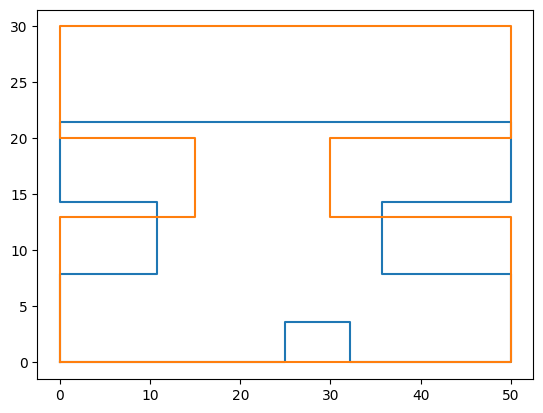

In [3]:
sites_list = [Polygon(((103.76762137358979,1.3087990670131122),(103.76695888021099,1.3091033941901744),(103.76695888021099,1.3091033941901782),(103.76680089609894,1.3087280864870512),(103.76679274742034,1.3087078172631332),(103.76678557945053,1.3086899861164933),(103.76677812454516,1.3086684317627417),(103.76677122299097,1.3086453681151176),(103.7667670091718,1.308629112978794),(103.76676302875474,1.308610442969295),(103.76675844145478,1.3085858620102093),(103.76675564607066,1.308568042468877),(103.7667533421893,1.3085446293791023),(103.76675190226392,1.3085256723620893),(103.76675180617868,1.3085231659641638),(103.76675217242752,1.3085144072545394),(103.7667522007742,1.3084925885686336),(103.76675194337425,1.3084860243757694),(103.76675179918865,1.3084809478597594),(103.7667517106069,1.3084758790108302),(103.7667516777277,1.3084708192010914),(103.76675170047343,1.3084657425356094),(103.76675178278158,1.3084603788857558),(103.76675190539342,1.3084553122515075),(103.76675209415393,1.3084502477405577),(103.76675234045226,1.3084448982895578),(103.76675262913469,1.3084398468137872),(103.76675297264875,1.3084347980204762),(103.76675337164095,1.308429760924249),(103.7667538265147,1.3084247131985483),(103.76675436383049,1.3084194076934133),(103.76675492029798,1.3084143621108462),(103.76675554278873,1.3084093157891215),(103.76675623518352,1.3084040881540013),(103.76675695186114,1.3083991144012195),(103.76675772636361,1.3083941199926599),(103.7667585981971,1.3083888850082213),(103.76675947173706,1.3083839153246697),(103.76676040667252,1.3083789760982625),(103.76676143482773,1.3083738029708472),(103.76676252125338,1.3083686400989731),(103.76676359985571,1.3083637364392524),(103.76676473694107,1.3083588713631675),(103.76676598859025,1.3083537327630061),(103.76676721542269,1.3083489250335345),(103.7667685661309,1.30834388081516),(103.76676998123311,1.3083387781575588),(103.7667713777606,1.3083339540246992),(103.76677288501628,1.3083289535549412),(103.76677431495274,1.3083243728196843),(103.76677594002432,1.308319412844347),(103.7667776044232,1.3083144450305626),(103.76677923565617,1.3083097919766917),(103.76678109463339,1.3083046375442602),(103.76678287287089,1.3082998556296206),(103.76678465129328,1.3082952392626963),(103.76678653966118,1.3082904938452273),(103.7667884690412,1.3082857914938295),(103.76679050494603,1.3082809810350113),(103.76679265220022,1.3082760417058086),(103.76679468914062,1.3082714786919092),(103.76679669853525,1.3082671254202085),(103.76679893802313,1.308262412675837),(103.76680124155497,1.3082576830310426),(103.76680345530123,1.3082532600238392),(103.76680579233569,1.3082487256194255),(103.76680831269016,1.3082439502444518),(103.76681077662153,1.308239388683786),(103.76681316405632,1.3082350862344916),(103.76681367260619,1.3082341941146542),(103.7670369584743,1.307915310591265),(103.7670369584743,1.3079153105912689),(103.76766580058731,1.308298877127881),(103.76766580058731,1.3082988771278814),(103.7676428514021,1.3083818967566208),(103.76764179810895,1.3083863255490304),(103.76762282479181,1.3084812464296733),(103.7676218261851,1.3084883025243677),(103.76761371619476,1.30858474385251),(103.76761349686825,1.3085895323950083),(103.76761275665643,1.3086863455250057),(103.76761291779121,1.3086913506228472),(103.7676198824296,1.308787898815235),(103.7676204205505,1.3087927382936007),(103.76762137358979,1.3087990670131138))),
              Polygon(((103.76881799558069,1.3113251436959874),(103.76881140669404,1.3113255727539448),(103.76873396113677,1.3113315665393301),(103.76872784263504,1.3113321102857496),(103.76865738056709,1.3113391824336829),(103.76839126471891,1.3113533462825622),(103.76838106854085,1.3113540831328867),(103.76835900052754,1.3113560993222997),(103.76833891785218,1.3113586981033494),(103.76831699267106,1.3113623775367729),(103.76830393468646,1.3113649016606184),(103.76822916610874,1.311381278147748),(103.76822326065329,1.3113826413806544),(103.76814908496362,1.3114006451884348),(103.76814328579329,1.3114021211198539),(103.76806951434554,1.3114217711079816),(103.76806369241301,1.3114233919786933),(103.76805063357534,1.3114271859332673),(103.76805063357534,1.3114271859332676),(103.76793435831124,1.3112195678874503),(103.76785570785277,1.3110483549485854),(103.767854909063,1.3110466321041037),(103.76783283523227,1.3109994591068697),(103.76778345246646,1.3108599918491781),(103.7677810570058,1.310853493215834),(103.76777568418207,1.3108394750826222),(103.76777019997111,1.310826231496659),(103.76776409052887,1.3108125214049136),(103.76776114891919,1.3108061449635922),(103.7677035103156,1.3106853657516602),(103.7676989924413,1.3106763377694812),(103.76768916217716,1.3106575804661729),(103.7676792703816,1.3106402915368032),(103.76766809354281,1.3106223308305385),(103.76766267840111,1.3106139769623915),(103.76760055230274,1.3105219074519354),(103.76759480278204,1.3105107430616825),(103.767537054323,1.3103985563959337),(103.76752057039474,1.310366533902596),(103.76751937486969,1.3103642385678935),(103.76744440558485,1.3102219736491236),(103.76743225026283,1.310198905858367),(103.76743066661837,1.3101959453563914),(103.76734150792808,1.3100317376402688),(103.7673397693827,1.3100285860524563),(103.76725723774882,1.3098813090027575),(103.76702004307234,1.309318039510132),(103.76702004307234,1.3093180395101274),(103.76767692458766,1.309016942764499),(103.76767692458766,1.3090169427645042),(103.76769177935024,1.3090558434512203),(103.76769263097744,1.309057957826232),(103.7677184530503,1.3091188584835525),(103.7677193520865,1.3091208791988285),(103.76797250724987,1.3096639600470876),(103.76798035681244,1.309681308153539),(103.76810629485455,1.309959512084365),(103.7681429619824,1.3100405173730216),(103.76818872560791,1.3101416202506384),(103.76824352221166,1.3102626758022258),(103.76824440209765,1.310264537846306),(103.76830279528608,1.3103830476364076),(103.76830295441698,1.3103833682895258),(103.76834752882135,1.3104725485665667),(103.76834849990372,1.3104744128344818),(103.76839591388273,1.3105618391575204),(103.76839618181492,1.3105623280126735),(103.76844411771513,1.3106488769082296),(103.76844515425438,1.3106506775505256),(103.76849661155047,1.3107367468682052),(103.76849738485257,1.3107380064697685),(103.76855069357646,1.3108225930541009),(103.76855129084,1.3108235225460931),(103.76860488702482,1.3109053421425187),(103.76860502290766,1.3109055486933838),(103.76865875501163,1.3109868763656687),(103.76870692933043,1.311070285492092),(103.76875105891605,1.3111566848241125),(103.76878968068795,1.311244243504477),(103.76881799558069,1.3113251436959852))),
            # Polygon(((103.9502369,1.3283904),(103.9505232,1.3277247),(103.9525938,1.3285024),(103.9521837,1.3291431),(103.9519125,1.3294435),(103.9502369,1.3283904))),
            #  Polygon(((103.9347477,1.3384172),(103.9347544,1.3383448),(103.9347819,1.3382832),(103.9349328,1.338078),(103.935199,1.3377301),(103.9353338,1.3374975),(103.9354324,1.3372696),(103.9355048,1.3370671),(103.9355476,1.3368769),(103.9376767,1.3371135),(103.9355323,1.3391707),(103.9351487,1.3387645),(103.9347692,1.3384742),(103.9347477,1.3384172))),
            #  Polygon(((103.9544223,1.3204243),(103.9545532,1.3201771),(103.9545116,1.3201523),(103.9547401,1.3197211),(103.9553594,1.3200968),(103.9548355,1.3208367),(103.9547314,1.320636),(103.9544223,1.3204243)))]#plot pologon
                ]   

building_list = [Polygon(((0,0),(0,1.1),(1.5,1.1),(1.5,2),(0,2),(0,3),(7,3),(7,2),(5,2),(5,1.1),(7,1.1),(7,0),(4.5,0),(4.5,0.5),(3.5,0.5),(3.5,0),(0,0))),
                #  Polygon(((103.9182582,1.3085852),(103.9183205,1.3085905),(103.9183188,1.3086104),(103.9184265,1.3086194),(103.9184281,1.3086003),(103.9185008,1.3086064),(103.9185052,1.3085546),(103.918517,1.3085556),(103.9185229,1.3084856),(103.9184491,1.3084794),(103.9184547,1.3084139),(103.9185317,1.3084204),(103.9185376,1.3083497),(103.9185245,1.3083486),(103.9185294,1.30829),(103.9184599,1.3082841),(103.9184613,1.3082676),(103.9183545,1.3082586),(103.9183532,1.3082739),(103.9182861,1.3082683),(103.9182817,1.3083201),(103.9182606,1.3083183),(103.9182541,1.3083954),(103.91833,1.3084018),(103.9183242,1.3084702),(103.9182504,1.308464),(103.9182443,1.3085359),(103.9182623,1.3085374),(103.9182582,1.3085852))),
                #  Polygon(((103.9180943,1.309182),(103.9182393,1.3091933),(103.9182464,1.3091028),(103.9182956,1.3091066),(103.9183064,1.308967),(103.9181121,1.3089519),(103.9180943,1.309182))),
                 Polygon(((0,0),(0,1.3),(1.5,1.3),(1.5,2),(0,2),(0,3),(5,3),(5,2),(3,2),(3,1.3),(5,1.3),(5,0),(0,0)))
                ]   
def resize_polygon(site,desired_scale  =50):
    X,Y = site.exterior.xy
    # scale x,y so that it is between 0to 10 range 

    # Calculate the scale factor to fit the polygon within a specific range
    current_width = max(X) - min(X)
    current_height = max(Y) - min(Y)

    longest_axis = max(current_width, current_height)
    scale_factor = desired_scale /longest_axis


    # Scale the polygon coordinates
    scaled_polygon_x = [(x- min(X)) * scale_factor  for x in X]
    scaled_polygon_y = [(y-min(Y)) * scale_factor  for y in Y]

    return scaled_polygon_x, scaled_polygon_y

fig, ax = plt.subplots()
for building in building_list:
    X,Y = resize_polygon(building)

    ax.plot(X,Y)

plt.show()

# RL Class


In [4]:
class SpaDesPlacement(gym.Env):
    def __init__(self,sites_list, building_list, grid_size=(50, 50), max_boxes=20, site_coverage= 0.3, interblock_distance = 1):
        super(SpaDesPlacement, self).__init__()
        self.grid_size = grid_size
        self.grid= np.zeros(self.grid_size, dtype=int)
        self.max_boxes = max_boxes
        self.site_coverage = site_coverage
        self.sites_list = sites_list
        self.site_boundary = self._generate_site(self.sites_list)
        self.building_list = building_list
        # Define the action space for continuous placement (x, y, length, width, height)
        self.action_space = spaces.Box(low=np.array([0,0,3,3,1]), high=np.array([1,1,7,7,9]), shape=(5,), dtype=float)

        # Define the state space to represent the current box positions and sizes
        # self.observation_space = spaces.Dict({'grid': spaces.MultiBinary(np.prod(grid_size) + max_boxes ),
        #                                       'site_boundary':spaces.Box(0,200,shape=(100,0), dtype= np.float32) } )
        self.observation_space = spaces.MultiBinary(np.prod(grid_size) + max_boxes*(self.action_space.shape[0]) + 200 + 3 ) # 200:coordinate of site_boundary,3 : constraints
        # self.observation_space = spaces.Box(0,200,shape=(np.prod(self.grid_size) + max_boxes,0), dtype= np.float32)                                 

        self.boxes_placed = 0
        self.boxes = np.empty((1,5), dtype=float)
        self.interblock_distance = interblock_distance
        self.total_footprint =0
        self.state = self._get_state()
        
        

    def reset(self, seed=1):
        self.boxes_placed = 0
        self.total_footprint = 0
        self.interblock_distance = np.random.uniform(1, 3)
        #give a value between 0.2 to 0.5
        self.site_coverage = np.random.uniform(0.2, 0.4)
        self.site_boundary = self._generate_site(self.sites_list)
        self.boxes = np.empty((1,5), dtype=float)
        self.state = self._get_state()
        self.grid = np.zeros(self.grid_size)
        flat_grid = self.grid.flatten()
        box_count = np.zeros(self.max_boxes * self.action_space.shape[0])
            
            # print(box_count)
        # self.state = np.concatenate([flat_grid, box_count,self.pad_polygon(self.site_boundary, 50)])
        self.state = np.concatenate([flat_grid, box_count,self.pad_polygon(self.site_boundary, 100),[self.site_coverage, self.max_boxes, self.interblock_distance]])
        # print(self.state.shape)
        return self.state, {}

    def step(self, action):
        # Execute an action (place a box) and return the next state, reward, and done flag
        if self.boxes_placed >= self.max_boxes:
            return self.state, -1, True, None, {}
        
        if not self._is_valid_site_coverage():
            return self.state, -5, True, None, {}
        
        

        x, y, width, length, height = action
        x, y, width, length, height  = math.floor(x*49.8), math.floor(y*49.8), width, length, height
        reward = 5
        # if not self.site_boundary.contains(Point(x,y)):
        #     return self.state, -1, False, {}
        if not self.site_boundary.contains(Polygon([(x, y),(x + width, y),(x + width, y + length),(x, y + length),(x, y)])):
            reward = -1
            # return self.state, -1, False, None, {}

        if not self._is_valid_placement(x, y, width, length, height):
            reward = -5
            # return self.state, -5, False, None, {}
        
        

        # self.boxes[self.boxes_placed] = [x, y, length, width, height]
        box = np.array([[x, y, width, length, height]])
        # reward = self.calculate_clear_view_reward(box, self.boxes)
        self.boxes = np.append(self.boxes, box, axis=0)
        self.boxes_placed += 1
        self.grid[x,y] = 1 
        self.state = self._get_state()
        # print(self.state)

        
       

        done = self.boxes_placed >= self.max_boxes

        return self.state, reward, done, None, {}
    
    def calculate_intersection_volume(self,box1, box2):
    # Calculate the intersection volume between two boxes
        x_overlap = max(0, min(box1[0] + box1[2], box2[0] + box2[2]) - max(box1[0] , box2[0] ))
        y_overlap = max(0, min(box1[1] + box1[3], box2[1] + box2[3]) - max(box1[1], box2[1]))
        z_overlap = max(0, min(box1[4], box2[4]) - max(box1.z, box2.z))

        intersection_volume = x_overlap * y_overlap * z_overlap
        return intersection_volume
    

    def calculate_clear_view_reward(self,box, other_boxes, offset = 5):
        # Calculate surrounding area for the given box
        offset_left = [box[0] - offset, box[1], offset, box[3], box[4]]
        offset_right = [box[0]+box[2],box[1],offset,box[3], box[4]]
        offset_bottom = [box[0],box[1]-offset,box[2],offset,box[4]]
        offset_top = [box[0],box[1]+box[3],box[2],offset,box[4]]
        
        for other_box in other_boxes:
            intersection_volume = self.calculate_intersection_volume(box, other_box)
            if intersection_volume > 0:
                # If there is an intersection, return a reward based on the clear view volume (between 0 and 1)
                clear_view_volume = (box.width * box.height * box.depth) - intersection_volume
                reward = clear_view_volume / (box.width * box.height * box.depth)
                return max(0, min(1, reward))

    # If the surrounding area is not blocked, return a reward of 1
        return 1    

    def _is_valid_placement(self, x, y, width, length, height):
        # Check if the placement is valid (no intersection with other boxes)
        new_box = Polygon([(x, y),(x + width, y),(x + width, y + length),(x, y + length),(x, y)])
        for i in range(self.boxes_placed):
            box = self.boxes[i]
            
            current_box = Polygon([(box[0] - self.interblock_distance, box[1] - self.interblock_distance),
                                   (box[0] + box[2] + self.interblock_distance, box[1] - self.interblock_distance),
                                   (box[0] + box[2] + self.interblock_distance, box[1] + box[3] + self.interblock_distance),
                                   (box[0] - self.interblock_distance, box[1] + box[3] - self.interblock_distance),
                                   (box[0] - self.interblock_distance, box[1] - self.interblock_distance)])
            # if (x < box[0] + box[2] and  # Right side of box1 is to the left of box2
            #     x + width > box[0] and   # Left side of box1 is to the right of box2
            #     y < box[1] + box[3] and   # Bottom side of box1 is above the top of box2
            #     y + length > box[1]       # Top side of box1 is below the bottom of box2
            #     ):
                # if buildings intersected
            if new_box.intersects(current_box):
                return False

        return True
    
   
    def _resize_polygon(self, site, desired_scale=50, center=None):
        X, Y = site.exterior.xy
        # print(site.exterior.xy)

        # Calculate the center of the polygon if a custom center is not provided
        

        # Calculate the scale factor to fit the polygon within a specific range
        current_width = max(X) - min(X)
        current_height = max(Y) - min(Y)
        # print(current_width, current_height)
        longest_axis = max(current_width, current_height)
        scale_factor = desired_scale / longest_axis

        if center is None:
            center_x = current_width / 2
            center_y = current_height / 2
        else:
            center_x, center_y = center

        # Scale and center the polygon coordinates
        scaled_polygon_x = [(x - min(X)) * scale_factor + center_x for x in X]
        scaled_polygon_y = [(y - min(Y)) * scale_factor + center_y for y in Y]
        

        return scaled_polygon_x, scaled_polygon_y
    
    def pad_polygon(self,polygon, target_length):
            current_length = len(polygon.exterior.xy[0])
            
            # Pad with zeros if the polygon has fewer vertices than the target length
            padding_length = max(0, target_length - current_length)
            padded_vertices_x = list(polygon.exterior.xy[0]) + [0] * padding_length
            padded_vertices_y = list(polygon.exterior.xy[1]) + [0] * padding_length
            
            return np.array(padded_vertices_x +  padded_vertices_y)
    
    def _get_state(self):
        flat_grid = self.grid.flatten()
        
        boxes = self.boxes[1:]
        box_count = np.zeros(self.max_boxes * self.action_space.shape[0])
        pad_box = self.max_boxes - self.boxes_placed
        for i in range(self.boxes_placed):
            start = i * self.action_space.shape[0]
            box_count[start] = boxes[i][0]
            box_count[start+1] = boxes[i][1]
            box_count[start+2] = boxes[i][2]
            box_count[start+3] = boxes[i][3]
            box_count[start+4] = boxes[i][4]
        
        # return {'grid':np.concatenate([flat_grid, box_count]),'site_boundary': site_boundary}
        return np.concatenate([flat_grid, box_count,self.pad_polygon(self.site_boundary,100),[self.site_coverage, self.max_boxes, self.interblock_distance]])
    
    # def _long_side_facing(self, x, y, width, length):
        
    
    def _is_valid_site_coverage(self):
        self.total_footprint = 0
        for i in range(self.boxes_placed):
            box = self.boxes[i]
            box_footprint = box[2] * box[3]
            self.total_footprint += box_footprint
        
        if (self.total_footprint/self.site_boundary.area > self.site_coverage):
            
            self.boxes=self.boxes[:-1]
            return False
        
        return True
    
    def _generate_site(self,sites_list):
        site = sites_list[random.randint(0,len(sites_list)-1)]
        x,y =  self._resize_polygon(site,self.grid_size[0])
        return Polygon(list(zip(x, y)))
    
    def render(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Create vertices for the building
        for i in range(len(self.boxes)):
            x = self.boxes[i][0]
            y = self.boxes[i][1]
            length = self.boxes[i][2]
            width = self.boxes[i][3]
            height = self.boxes[i][4]
            building = self._generate_site(self.building_list)

            polygon_x, polygon_y = building.exterior.xy

            #scale x,y to range [0,1]
            # polygon_x, polygon_y = 
            
            # vertices = np.vstack([scaled_polygon, scaled_polygon + [0, 0, height]])
            # print(vertices)
            building_polygon = Polygon(((103.9370357, 1.3143551),
            (103.9370357, 1.3129232),
            (103.9372625, 1.3129232),
            (103.9372625, 1.3134300),
            (103.9375333, 1.3134300),
            (103.9375333, 1.3129232),
            (103.9377601, 1.3129232),
            (103.9377601, 1.3143551),
            (103.9375333, 1.3143551),
            (103.9375333, 1.3139200),
            (103.9372625, 1.3139200),
            (103.9372625, 1.3143551),
            (103.9370357, 1.3143551)
        ))

            polygon_coords_2d = self._resize_polygon(building_polygon,length,(x,y))
            # print((x,y))

            polygon_coords_2d = list(zip(polygon_coords_2d[0], polygon_coords_2d[1]))

            
            polygon_coords_3d = [(x, y, 0) for x, y in polygon_coords_2d]  # Bottom face
            polygon_coords_3d_top = [(x, y, height) for x, y in polygon_coords_2d]  # Top face

            # Create the polygon faces
            verts = [polygon_coords_3d, polygon_coords_3d_top]

            # Plot the 3D polygon
            poly3d = [[verts[0][i], verts[0][i + 1], verts[1][i + 1], verts[1][i]] for i in range(len(verts[0]) - 1)]

            # Define faces of the building
            # faces = [
            #     [vertices[0], vertices[1], vertices[5], vertices[4]],
            #     [vertices[7], vertices[6], vertices[2], vertices[3]],
            #     [vertices[0], vertices[4], vertices[7], vertices[3]],
            #     [vertices[1], vertices[5], vertices[6], vertices[2]],
            #     [vertices[4], vertices[5], vertices[6], vertices[7]]
            # ]

            # Plot the building
            # ax.add_collection3d(Poly3DCollection(poly3d, facecolors='cyan', linewidths=1, edgecolors='r', alpha=.5))


            vertices = np.array([
                [x, y, 0],
                [x, y + width, 0],
                [x + length, y + width, 0],
                [x + length, y, 0],
                [x, y, height],
                [x, y + width, height],
                [x + length, y + width, height],
                [x + length, y, height]
            ])
            

            # Define faces of the building
            faces = [
                [vertices[0], vertices[1], vertices[5], vertices[4]],
                [vertices[7], vertices[6], vertices[2], vertices[3]],
                [vertices[0], vertices[4], vertices[7], vertices[3]],
                [vertices[1], vertices[5], vertices[6], vertices[2]],
                [vertices[4], vertices[5], vertices[6], vertices[7]]
            ]

            # Plot the building
            ax.add_collection3d(Poly3DCollection(faces, facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))

            # Set axis labels
            ax.plot(list(self.site_boundary.exterior.xy[0]),list(self.site_boundary.exterior.xy[1])  , alpha=0.5)
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')

        # Set plot limits
        ax.set_xlim([0, self.grid_size[0]])
        ax.set_ylim([0, self.grid_size[1]])
        ax.set_zlim([0, 10])

        # Display the plot
        plt.show()
        print(self.state)
        self.total_footprint = 0
        for i in range(self.boxes_placed):
            box = self.boxes[i]
            box_footprint = box[2] * box[3]
            self.total_footprint += box_footprint
        print('site coverage ', self.total_footprint/self.site_boundary.area)

        

In [5]:
env = SpaDesPlacement(sites_list,building_list)
obs = env.reset()

# Sample action: (x, y, length, width, height)
action = np.array([0.4, 0.4, 0.3, 0.2, 0.1])
obs, reward, done, _,_ = env.step(action)
action = np.array([0.7, 0.6, 0.3, 0.2, 0.1])
obs, reward, done, _,_ = env.step(action)
print("Next state (box placement):")

Next state (box placement):


In [384]:
model = PPO('MlpPolicy', env, verbose=1)
# Train the agent
model.learn(total_timesteps=10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
(2803,)
---------------------------------
| rollout/           |          |
|    ep_len_me

(2803,)


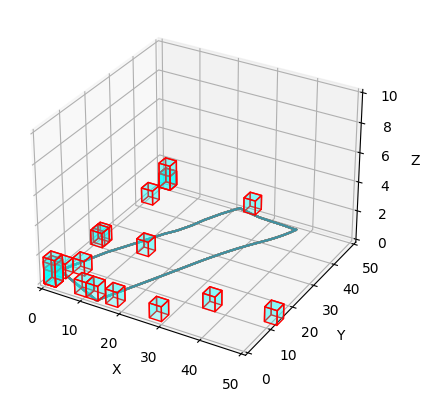

[ 1.          0.          0.         ...  0.26611119 20.
  1.78983273]
site coverage  0.22682322940647429


In [407]:
obs, info = env.reset()
while True:
# for _ in range(1000):
    action, _ = model.predict(obs)
    
    obs, _, done, _, _= env.step(action)
    #reshpare a list to np.array (10x10)
 
    if done:

        # print(np.array(obs[:100]).reshape(10,10))
        # print('boxes placed:\n ',env.boxes)
        # obs = env.reset()
        # print('done')
        break

env.render()

In [ ]:
import torch
import time
date = time.strftime("%Y-%m-%d")
save_path = f'ppo_model_v3_{date}.pth'

# Save the entire model
model.save(save_path)

In [ ]:
import os
load_path = "../RL/ppo_model_v3_2023-11-22.pth"

# Load the model

if os.path.exists(load_path):
    model = PPO.load(load_path)
    # Continue with your code
else:
    print(f"The file {load_path} does not exist.")